Successfully built the HTN.


max_dm=9.70810268158262e-06:   7%|▋         | 103/1500 [00:00<00:09, 154.92it/s] 


Free entropy from BP: 99.78111352865281, density: 0.3443354647735413, T: 3, chemical_potential: -3


s13,10->0: 100%|██████████| 400/400 [00:00<00:00, 1767.08it/s]


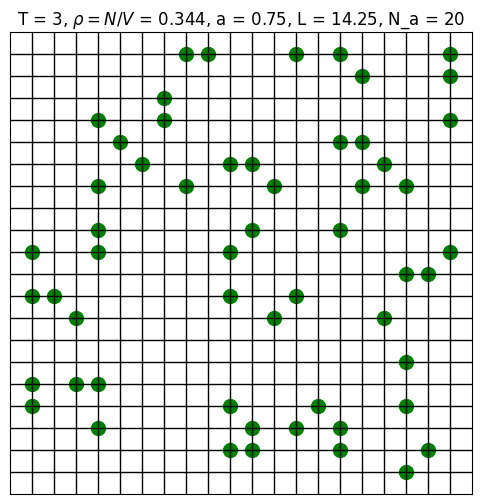

Successfully built the HTN.


max_dm=9.959237469603366e-06:  22%|██▏       | 331/1500 [00:02<00:07, 165.30it/s] 


Free entropy from BP: 124.90563177908021, density: 0.3978523356120964, T: 3, chemical_potential: -2


s19,15->0: 100%|██████████| 400/400 [00:00<00:00, 1643.15it/s]


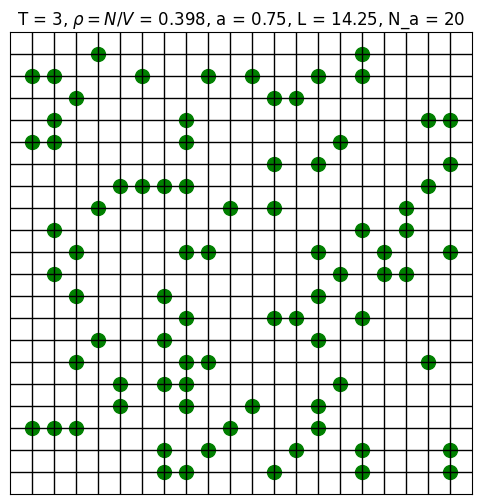

Successfully built the HTN.


max_dm=9.639071270273192e-06:  16%|█▋        | 246/1500 [00:01<00:07, 165.91it/s] 


Free entropy from BP: 160.20046887001604, density: 0.632127797188849, T: 3, chemical_potential: -1


s5,3->1: 100%|██████████| 400/400 [00:00<00:00, 1702.24it/s]


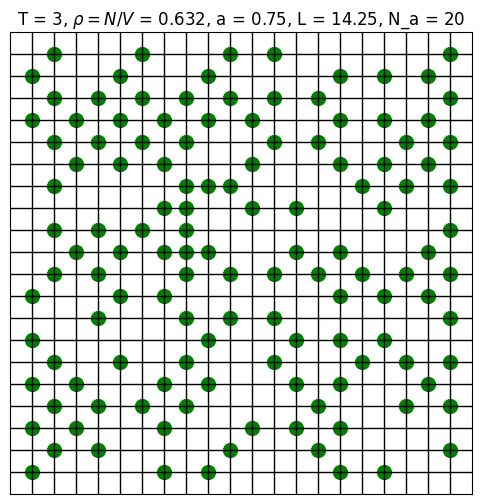

Successfully built the HTN.


max_dm=8.49593474944177e-06:   9%|▉         | 133/1500 [00:00<00:07, 182.00it/s]  


Free entropy from BP: 207.65417955468564, density: 0.757787992314122, T: 3, chemical_potential: 0


s5,6->1: 100%|██████████| 400/400 [00:00<00:00, 1125.30it/s] 


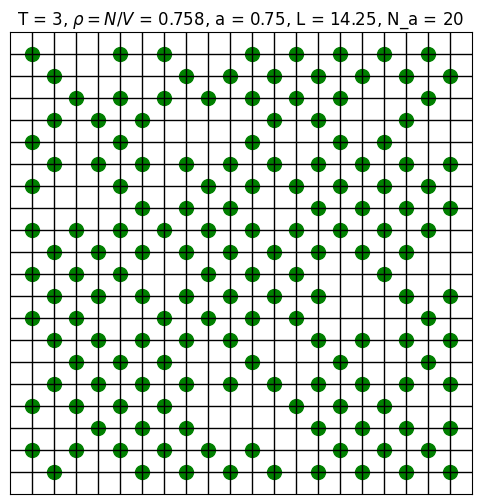

Successfully built the HTN.


max_dm=7.19068710880455e-06:   9%|▉         | 136/1500 [00:00<00:08, 162.32it/s]


Free entropy from BP: 261.6580865364302, density: 0.8320704686636837, T: 3, chemical_potential: 1


s1,8->1: 100%|██████████| 400/400 [00:00<00:00, 1648.77it/s] 


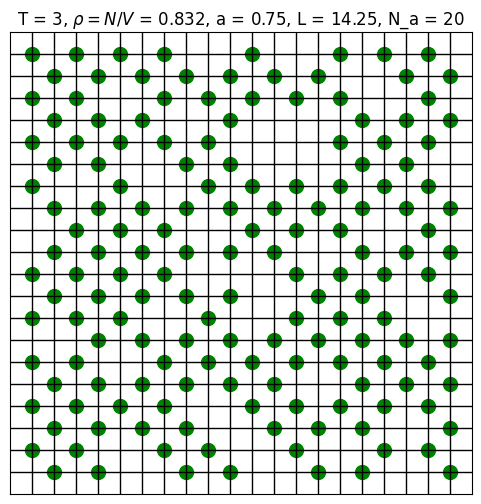

Successfully built the HTN.


max_dm=7.224552140763785e-06:   8%|▊         | 123/1500 [00:00<00:08, 158.20it/s]


Free entropy from BP: 319.70333475774436, density: 0.8797094199158911, T: 3, chemical_potential: 2


s11,4->1: 100%|██████████| 400/400 [00:00<00:00, 1695.12it/s] 


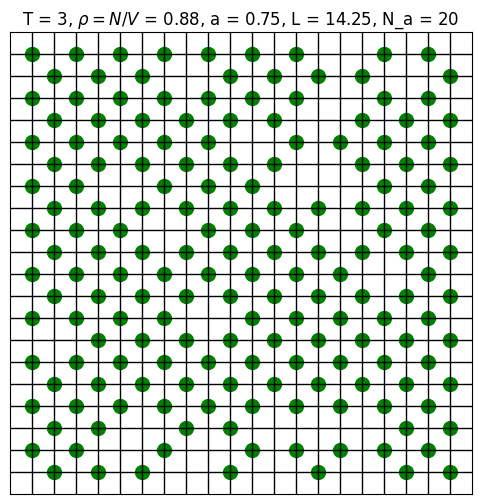

In [13]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np
import tnmpa.solvers.quimb_vbp as qbp
import sys

a = 0.75  # Lattice constant of the underlying simple cubic lattice (in reduced units)
N_a = 20  # Number of lattice points along one direction
L = a * (N_a - 1)  # Length of the cubic box
N = N_a**2  # Total number of lattice
uv = False  # Whether to use UV cutoff
density_compute = True
# chemical_potential = 5
chemical_potential_list = np.arange(-3,3,1)
# chemical_potential_list = [0]
reuse = True

dT = 0.1
# T_list = np.arange(1.5, 2, dT)
T_list = [3]
# T_list = np.arange(15.0, 10.0, dT)

cutoff = 3.0  # Cutoff distance for LJ potential
epsilon = 1.0  # Depth of the potential well/ Energy unit scale
sigma = 1.0  # Length scale in LJ potential, also the distance at which the potential becomes zero


# entropy_exact = np.log(contract_HTN_partition(tn))


for T in T_list:
    for chemical_potential in chemical_potential_list:
        beta = 1/T

        tn = qtn.tensor_builder.HTN2D_classical_LennardJones_partition_function(
            Lx=L,Ly=L,
            beta=beta,
            Nx=N_a,Ny=N_a,
            cutoff=cutoff,
            epsilon=epsilon,
            sigma=sigma,
            uv_cutoff=uv,
            chemical_potential=chemical_potential,
            cyclic=True,
            )
        # BP
        converged = False
        tol = 1e-5
        count = 0
        max_dm = 0
        damping_eta = 4e-1
        max_dm_cache = 0
        messages_cache = None

        beta = 1/T
        while not converged:

            if count > 0:
                damping_eta += 5e-2
        
            print('Successfully built the HTN.')

            messages, converged, max_dm = qbp.run_belief_propagation(
            tn, 
            tol=tol,
            max_iterations=1500,
            messages=messages_cache,
            progbar=True,
            thread_pool=8,
            uniform=False,
            damping=True,
            eta=damping_eta,
            show_max_dm=True,
            )

            max_dm_cache = max_dm

            if reuse:
                messages_cache = messages

            entropy_bp = qbp.compute_free_entropy_from_messages(tn, messages)
            density=0
            if density_compute:
                marginal = qbp.compute_all_index_marginals_from_messages(tn, messages)
                key_format='s{},{}'
                # Compute the density
                density = 0
                for i in range(N_a):
                    for j in range(N_a):
                        key = key_format.format(i,j)
                        density += marginal[key][1]
                density /= L**2
            
        print(f'Free entropy from BP: {entropy_bp}, density: {density}, T: {T}, chemical_potential: {chemical_potential}')
        config_dict = qbp.sample_belief_propagation_no_bp(tn, messages, None,progbar=True)
        config_dict=config_dict[0]
        # plot a 2D configuration from the config_dict
        # The keys are the 2d coordinates and the values are the particle types (holes or particles)

        import matplotlib.pyplot as plt
        import matplotlib as mpl
        import matplotlib.colors as colors


        # Plot the configuration
        fig, ax = plt.subplots(figsize=(6,6))

        # Plot the lattice grid
        for i in range(N_a):
            ax.plot([i, i], [-1, N_a], color='k', lw=1)
            ax.plot([-1, N_a], [i, i], color='k', lw=1)

        # Plot the particles
        pattern = 's{},{}'
        for i in range(N_a):
            for j in range(N_a):
                key = pattern.format(i,j)
                if config_dict[key] == 1:
                    ax.scatter(i, j, marker='o', color='g', s=100, label='Particle')
                # elif config_dict[key] == 0:
                #     ax.scatter(i, j, marker='o', color='k', s=100)



        ax.set_xlim(-1, N_a)
        ax.set_ylim(-1, N_a)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(r'T = {}, $\rho=N/V$ = {}, a = {}, L = {}, N_a = {}'.format(T, round(density,3), a, L, N_a))
        plt.show()

Successfully built the HTN.


max_dm=9.403512362032851e-06:   4%|▍         | 104/2500 [00:01<00:25, 95.34it/s] 


Free entropy from BP: 271.6473621955118, density: 0.5228259082282154, T: 3, chemical_potential: 0


s13,9->0: 100%|██████████| 625/625 [00:00<00:00, 1153.73it/s] 


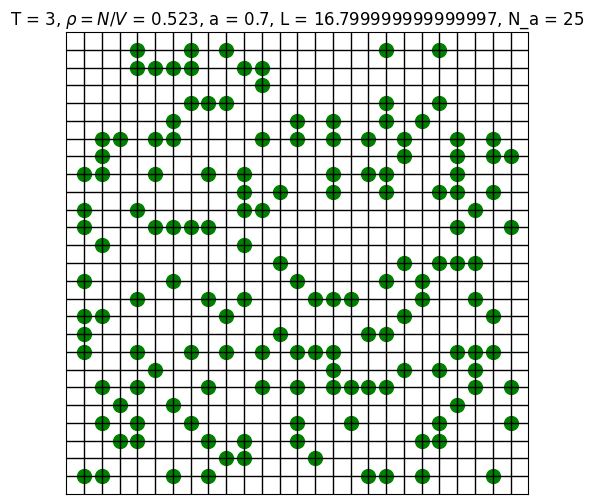

Successfully built the HTN.


max_dm=9.785403620843347e-06:   9%|▉         | 228/2500 [00:02<00:23, 95.43it/s] 


Free entropy from BP: 323.22772648825924, density: 0.5731568983227694, T: 3, chemical_potential: 1


s17,17->0: 100%|██████████| 625/625 [00:00<00:00, 1094.66it/s]


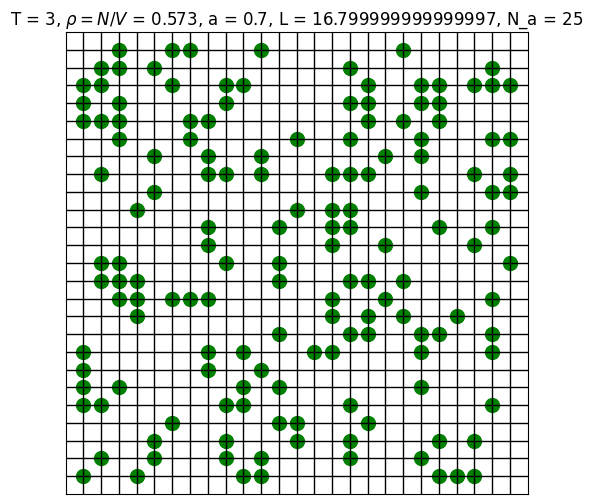

Successfully built the HTN.


max_dm=9.964746378876566e-06:  43%|████▎     | 1077/2500 [00:11<00:14, 95.79it/s] 


Free entropy from BP: 380.4255799610405, density: 0.6705623374019739, T: 3, chemical_potential: 2


s14,20->0: 100%|██████████| 625/625 [00:00<00:00, 1016.63it/s]


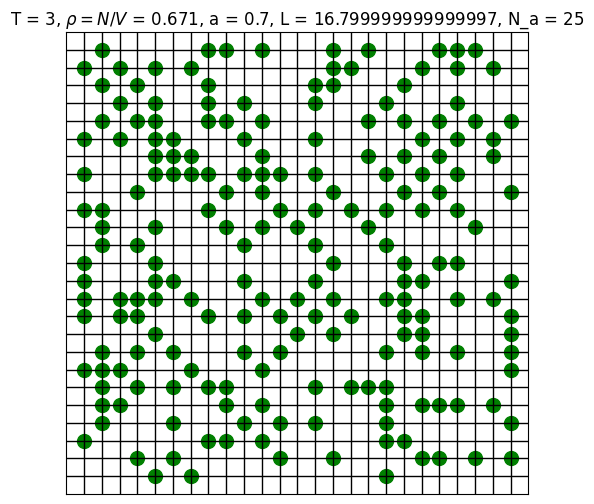

Successfully built the HTN.


max_dm=9.990255317560148e-06:  41%|████      | 1025/2500 [00:10<00:15, 94.28it/s] 


Free entropy from BP: 449.5646532124247, density: 0.7900794888256827, T: 3, chemical_potential: 3


s13,4->0: 100%|██████████| 625/625 [00:00<00:00, 1254.26it/s]


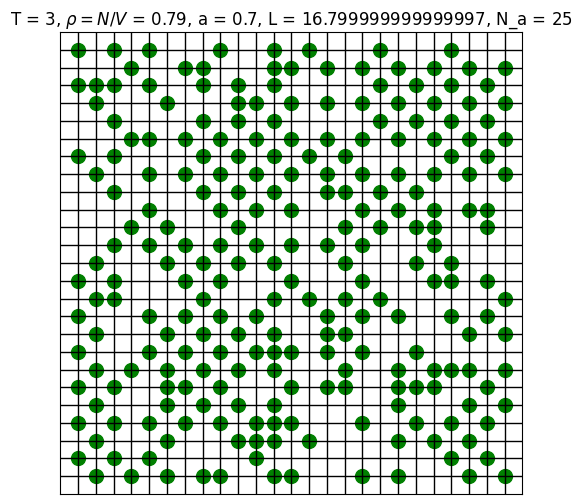

Successfully built the HTN.


max_dm=9.985792691680206e-06:  41%|████      | 1022/2500 [00:10<00:15, 96.01it/s] 


Free entropy from BP: 527.7963974517952, density: 0.8678768093601898, T: 3, chemical_potential: 4


s4,16->0: 100%|██████████| 625/625 [00:00<00:00, 1168.89it/s] 


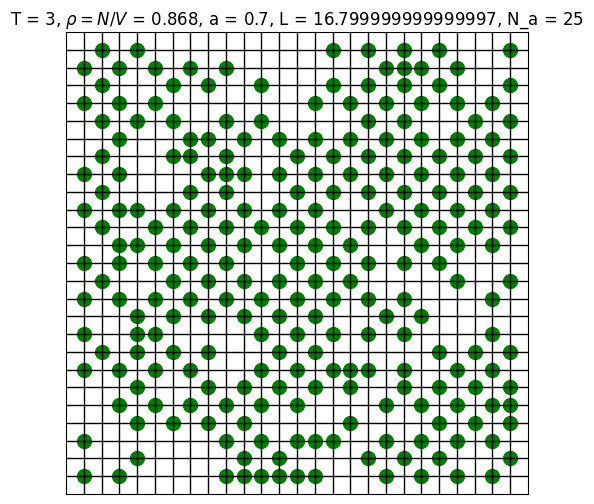

Successfully built the HTN.


max_dm=0.00014857771333443015: 100%|██████████| 2500/2500 [00:26<00:00, 96.05it/s] 


Successfully built the HTN.


max_dm=5.520660597441163e-05: 100%|██████████| 2500/2500 [00:26<00:00, 94.01it/s]  


Successfully built the HTN.


max_dm=1.0463341205413368e-05: 100%|██████████| 2500/2500 [00:25<00:00, 98.16it/s] 


Successfully built the HTN.


max_dm=9.999347415856619e-06:   3%|▎         | 66/2500 [00:00<00:23, 103.00it/s] 


Free entropy from BP: 612.1093963247844, density: 0.9213267367272491, T: 3, chemical_potential: 5


s11,11->0: 100%|██████████| 625/625 [00:00<00:00, 1343.56it/s]


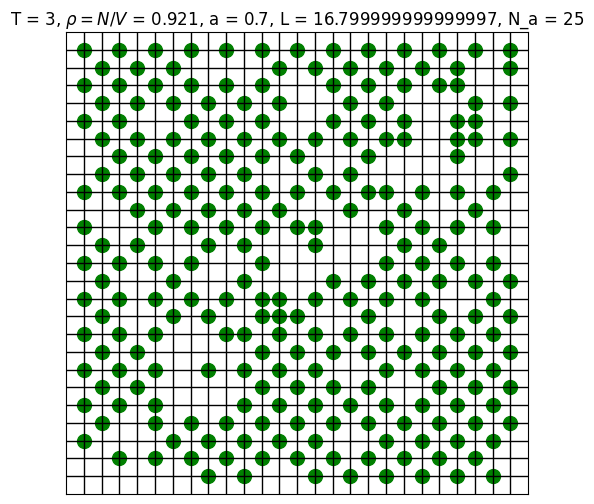

Successfully built the HTN.


max_dm=9.989875867089104e-06:  81%|████████  | 2029/2500 [00:20<00:04, 100.59it/s] 


Free entropy from BP: 700.6698660060741, density: 0.9592408154491592, T: 3, chemical_potential: 6


s24,23->1: 100%|██████████| 625/625 [00:00<00:00, 1411.42it/s]


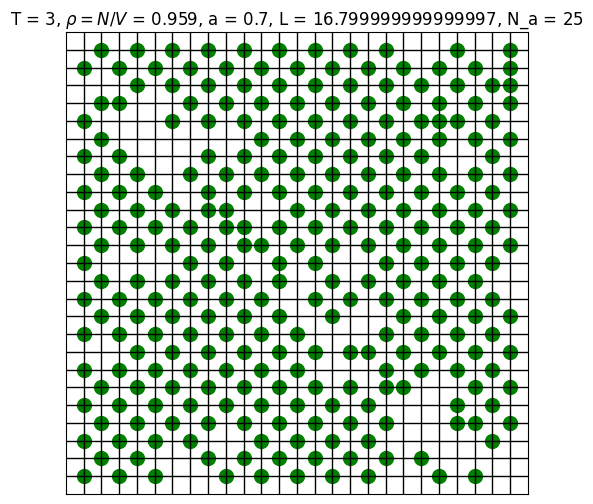

Successfully built the HTN.


max_dm=9.954402281908692e-06:  52%|█████▏    | 1304/2500 [00:13<00:12, 93.67it/s]  


Free entropy from BP: 792.2716781190206, density: 0.9866214079699548, T: 3, chemical_potential: 7


s13,15->1: 100%|██████████| 625/625 [00:00<00:00, 1307.19it/s]


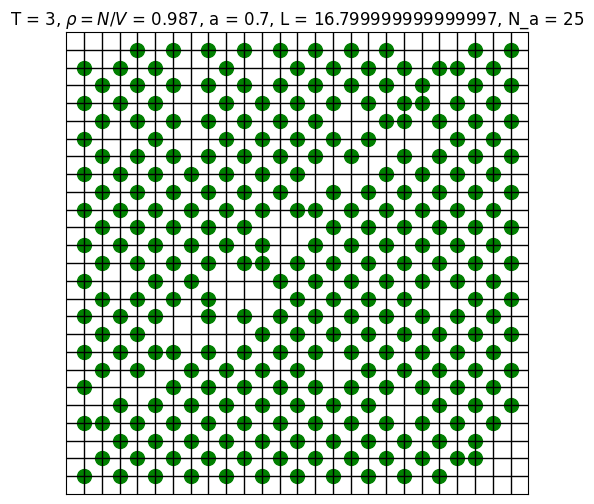

Successfully built the HTN.


max_dm=9.955751859636042e-06:  35%|███▍      | 871/2500 [00:09<00:17, 94.02it/s] 


Free entropy from BP: 886.0809987843917, density: 1.00658525559639, T: 3, chemical_potential: 8


s21,1->1: 100%|██████████| 625/625 [00:00<00:00, 1250.80it/s] 


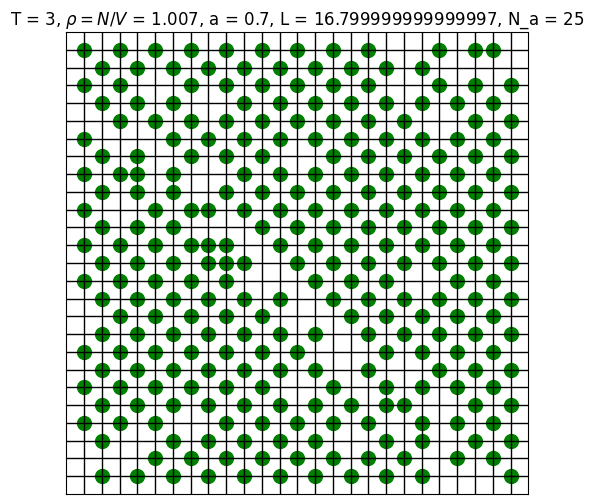

Successfully built the HTN.


max_dm=9.828911667952855e-06:  16%|█▋        | 412/2500 [00:04<00:21, 98.42it/s]  


Free entropy from BP: 981.5040184336679, density: 1.0212118570568998, T: 3, chemical_potential: 9


s17,18->0: 100%|██████████| 625/625 [00:00<00:00, 1169.67it/s]


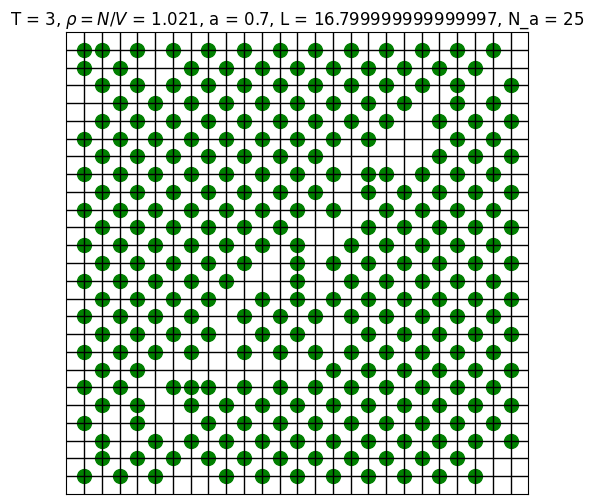

In [15]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np
import tnmpa.solvers.quimb_vbp as qbp
import sys

a = 0.70  # Lattice constant of the underlying simple cubic lattice (in reduced units)
N_a = 25  # Number of lattice points along one direction
L = a * (N_a - 1)  # Length of the cubic box
N = N_a**2  # Total number of lattice
uv = False  # Whether to use UV cutoff
density_compute = True
# chemical_potential = 5
chemical_potential_list = np.arange(0,10,1)
# chemical_potential_list = [0]
reuse = True

dT = 0.1
# T_list = np.arange(1.5, 2, dT)
T_list = [3]
# T_list = np.arange(15.0, 10.0, dT)

cutoff = 3.0  # Cutoff distance for LJ potential
epsilon = 1.0  # Depth of the potential well/ Energy unit scale
sigma = 1.0  # Length scale in LJ potential, also the distance at which the potential becomes zero


# entropy_exact = np.log(contract_HTN_partition(tn))


for T in T_list:
    for chemical_potential in chemical_potential_list:
        beta = 1/T

        tn = qtn.tensor_builder.HTN2D_classical_LennardJones_partition_function(
            Lx=L,Ly=L,
            beta=beta,
            Nx=N_a,Ny=N_a,
            cutoff=cutoff,
            epsilon=epsilon,
            sigma=sigma,
            uv_cutoff=uv,
            chemical_potential=chemical_potential,
            cyclic=True,
            )
        # BP
        converged = False
        tol = 1e-5
        count = 0
        max_dm = 0
        damping_eta = 4e-1
        max_dm_cache = 0
        messages_cache = None

        beta = 1/T
        while not converged:

            if count > 0:
                damping_eta += 5e-2
        
            print('Successfully built the HTN.')

            messages, converged, max_dm = qbp.run_belief_propagation(
            tn, 
            tol=tol,
            max_iterations=2500,
            messages=messages_cache,
            progbar=True,
            thread_pool=8,
            uniform=False,
            damping=True,
            eta=damping_eta,
            show_max_dm=True,
            )

            max_dm_cache = max_dm

            if reuse:
                messages_cache = messages

            entropy_bp = qbp.compute_free_entropy_from_messages(tn, messages)
            density=0
            if density_compute:
                marginal = qbp.compute_all_index_marginals_from_messages(tn, messages)
                key_format='s{},{}'
                # Compute the density
                density = 0
                for i in range(N_a):
                    for j in range(N_a):
                        key = key_format.format(i,j)
                        density += marginal[key][1]
                density /= L**2
            
        print(f'Free entropy from BP: {entropy_bp}, density: {density}, T: {T}, chemical_potential: {chemical_potential}')
        config_dict = qbp.sample_belief_propagation_no_bp(tn, messages, None,progbar=True)
        config_dict=config_dict[0]
        # plot a 2D configuration from the config_dict
        # The keys are the 2d coordinates and the values are the particle types (holes or particles)

        import matplotlib.pyplot as plt
        import matplotlib as mpl
        import matplotlib.colors as colors


        # Plot the configuration
        fig, ax = plt.subplots(figsize=(6,6))

        # Plot the lattice grid
        for i in range(N_a):
            ax.plot([i, i], [-1, N_a], color='k', lw=1)
            ax.plot([-1, N_a], [i, i], color='k', lw=1)

        # Plot the particles
        pattern = 's{},{}'
        for i in range(N_a):
            for j in range(N_a):
                key = pattern.format(i,j)
                if config_dict[key] == 1:
                    ax.scatter(i, j, marker='o', color='g', s=100, label='Particle')
                # elif config_dict[key] == 0:
                #     ax.scatter(i, j, marker='o', color='k', s=100)



        ax.set_xlim(-1, N_a)
        ax.set_ylim(-1, N_a)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(r'T = {}, $\rho=N/V$ = {}, a = {}, L = {}, N_a = {}'.format(T, round(density,3), a, L, N_a))
        plt.show()

Successfully built the HTN.


max_dm=9.203042316385801e-06:   1%|          | 26/2500 [00:00<00:22, 108.03it/s]


Free entropy from BP: 21.29179682195046, density: 0.06272312883910128, T: 3, chemical_potential: -10


s18,15->0: 100%|██████████| 625/625 [02:01<00:00,  5.15it/s]


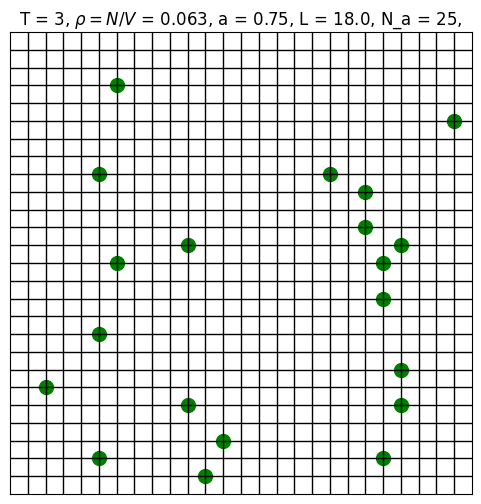

Successfully built the HTN.


max_dm=8.096668377033378e-06:   2%|▏         | 48/2500 [00:00<00:19, 125.46it/s]


Free entropy from BP: 94.35286165797926, density: 0.2340404333288055, T: 3, chemical_potential: -5


s22,16->0: 100%|██████████| 625/625 [02:00<00:00,  5.18it/s]


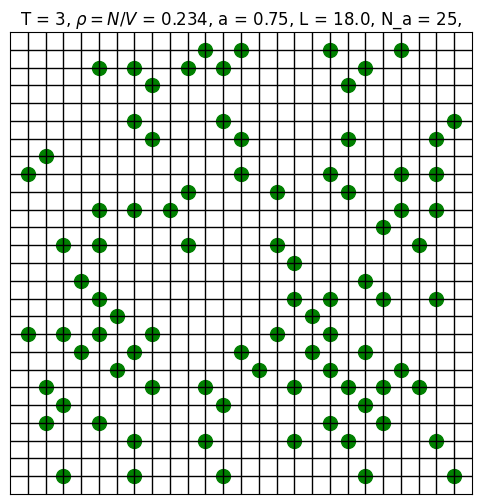

Successfully built the HTN.


max_dm=2.884756400628463e-05: 100%|██████████| 2500/2500 [00:19<00:00, 131.25it/s] 


Free entropy from BP: 314.2339449412885, density: 0.6856415204979588, T: 3, chemical_potential: 0


s16,10->0: 100%|██████████| 625/625 [02:01<00:00,  5.13it/s]


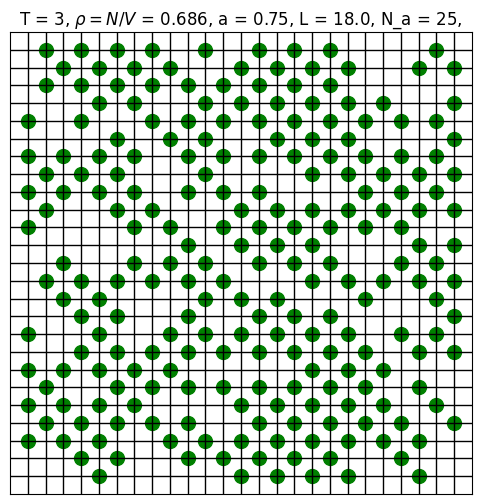

In [28]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np
import tnmpa.solvers.quimb_vbp as qbp
import sys

a = 0.75  # Lattice constant of the underlying simple cubic lattice (in reduced units)
N_a = 25  # Number of lattice points along one direction
L = a * (N_a - 1)  # Length of the cubic box
N = N_a**2  # Total number of lattice
uv = False  # Whether to use UV cutoff
density_compute = True
# chemical_potential = 5
chemical_potential_list = np.arange(-10,5,5)
# chemical_potential_list = [0]
reuse = False

dT = 0.1
# T_list = np.arange(1.5, 2, dT)
T_list = [3]
# T_list = np.arange(15.0, 10.0, dT)

cutoff = 3.0  # Cutoff distance for LJ potential
epsilon = 1.0  # Depth of the potential well/ Energy unit scale
sigma = 1.0  # Length scale in LJ potential, also the distance at which the potential becomes zero


# entropy_exact = np.log(contract_HTN_partition(tn))


for T in T_list:
    for chemical_potential in chemical_potential_list:
        beta = 1/T

        tn = qtn.tensor_builder.HTN2D_classical_LennardJones_partition_function(
            Lx=L,Ly=L,
            beta=beta,
            Nx=N_a,Ny=N_a,
            cutoff=cutoff,
            epsilon=epsilon,
            sigma=sigma,
            uv_cutoff=uv,
            chemical_potential=chemical_potential,
            cyclic=True,
            )
        # BP
        converged = False
        tol = 1e-5
        count = 0
        max_dm = 0
        damping_eta = 4e-1
        max_dm_cache = 0
        messages_cache = None

        beta = 1/T
        while not converged:

            if count > 0:
                damping_eta += 5e-2
        
            print('Successfully built the HTN.')

            messages, converged, max_dm = qbp.run_belief_propagation(
            tn, 
            tol=tol,
            max_iterations=2500,
            messages=messages_cache,
            progbar=True,
            thread_pool=8,
            uniform=False,
            damping=True,
            eta=damping_eta,
            show_max_dm=True,
            )

            max_dm_cache = max_dm

            if reuse:
                messages_cache = messages

            entropy_bp = qbp.compute_free_entropy_from_messages(tn, messages)
            density=0
            if density_compute:
                marginal = qbp.compute_all_index_marginals_from_messages(tn, messages)
                key_format='s{},{}'
                # Compute the density
                density = 0
                for i in range(N_a):
                    for j in range(N_a):
                        key = key_format.format(i,j)
                        density += marginal[key][1]
                density /= L**2
            count += 1
            if count>0:
                break
            
        print(f'Free entropy from BP: {entropy_bp}, density: {density}, T: {T}, chemical_potential: {chemical_potential}')
        config_dict = qbp.sample_belief_propagation(tn, messages, None,progbar=True)
        config_dict=config_dict[0]
        # plot a 2D configuration from the config_dict
        # The keys are the 2d coordinates and the values are the particle types (holes or particles)

        import matplotlib.pyplot as plt
        import matplotlib as mpl
        import matplotlib.colors as colors


        # Plot the configuration
        fig, ax = plt.subplots(figsize=(6,6))

        # Plot the lattice grid
        for i in range(N_a):
            ax.plot([i, i], [-1, N_a], color='k', lw=1)
            ax.plot([-1, N_a], [i, i], color='k', lw=1)

        # Plot the particles
        pattern = 's{},{}'
        for i in range(N_a):
            for j in range(N_a):
                key = pattern.format(i,j)
                if config_dict[key] == 1:
                    ax.scatter(i, j, marker='o', color='g', s=100, label='Particle')
                # elif config_dict[key] == 0:
                #     ax.scatter(i, j, marker='o', color='k', s=100)



        ax.set_xlim(-1, N_a)
        ax.set_ylim(-1, N_a)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(r'T = {}, $\rho=N/V$ = {}, a = {}, L = {}, N_a = {},'.format(T, round(density,3), a, L, N_a))
        plt.show()

Successfully built the HTN.


max_dm=9.087404037710911e-06:   9%|▉         | 223/2500 [00:01<00:19, 114.33it/s]


Free entropy from BP: 10238.502134039802, density: 0.9259259259259259, T: 3, chemical_potential: 100


s21,6->0: 100%|██████████| 625/625 [02:04<00:00,  5.01it/s] 


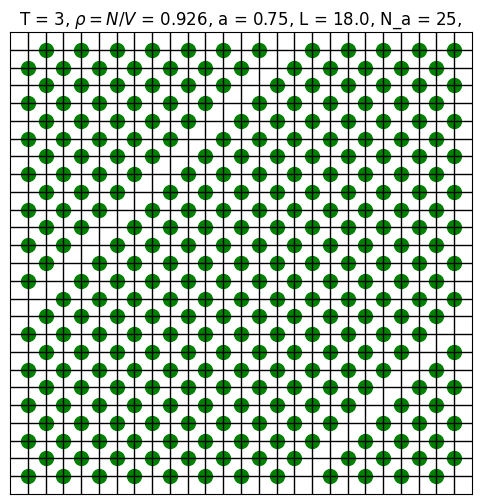

Successfully built the HTN.


max_dm=9.941098138954718e-06:  63%|██████▎   | 1585/2500 [00:13<00:07, 121.72it/s] 


Free entropy from BP: 15193.099654532647, density: 0.9351859394149152, T: 3, chemical_potential: 150


s5,19->0: 100%|██████████| 625/625 [02:01<00:00,  5.15it/s] 


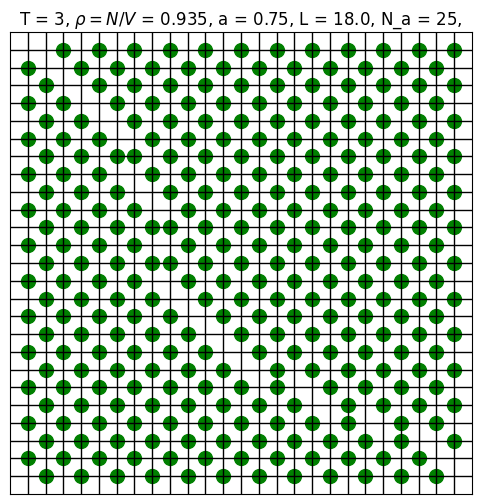

In [29]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np
import tnmpa.solvers.quimb_vbp as qbp
import sys

a = 0.75  # Lattice constant of the underlying simple cubic lattice (in reduced units)
N_a = 25  # Number of lattice points along one direction
L = a * (N_a - 1)  # Length of the cubic box
N = N_a**2  # Total number of lattice
uv = False  # Whether to use UV cutoff
density_compute = True
# chemical_potential = 5
chemical_potential_list = np.arange(100,200,50)
# chemical_potential_list = [0]
reuse = False

dT = 0.1
# T_list = np.arange(1.5, 2, dT)
T_list = [3]
# T_list = np.arange(15.0, 10.0, dT)

cutoff = 3.0  # Cutoff distance for LJ potential
epsilon = 1.0  # Depth of the potential well/ Energy unit scale
sigma = 1.0  # Length scale in LJ potential, also the distance at which the potential becomes zero


# entropy_exact = np.log(contract_HTN_partition(tn))


for T in T_list:
    for chemical_potential in chemical_potential_list:
        beta = 1/T

        tn = qtn.tensor_builder.HTN2D_classical_LennardJones_partition_function(
            Lx=L,Ly=L,
            beta=beta,
            Nx=N_a,Ny=N_a,
            cutoff=cutoff,
            epsilon=epsilon,
            sigma=sigma,
            uv_cutoff=uv,
            chemical_potential=chemical_potential,
            cyclic=True,
            )
        # BP
        converged = False
        tol = 1e-5
        count = 0
        max_dm = 0
        damping_eta = 4e-1
        max_dm_cache = 0
        messages_cache = None

        beta = 1/T
        while not converged:

            if count > 0:
                damping_eta += 5e-2
        
            print('Successfully built the HTN.')

            messages, converged, max_dm = qbp.run_belief_propagation(
            tn, 
            tol=tol,
            max_iterations=2500,
            messages=messages_cache,
            progbar=True,
            thread_pool=8,
            uniform=False,
            damping=True,
            eta=damping_eta,
            show_max_dm=True,
            )

            max_dm_cache = max_dm

            if reuse:
                messages_cache = messages

            entropy_bp = qbp.compute_free_entropy_from_messages(tn, messages)
            density=0
            if density_compute:
                marginal = qbp.compute_all_index_marginals_from_messages(tn, messages)
                key_format='s{},{}'
                # Compute the density
                density = 0
                for i in range(N_a):
                    for j in range(N_a):
                        key = key_format.format(i,j)
                        density += marginal[key][1]
                density /= L**2
            count += 1
            if count>0:
                break
            
        print(f'Free entropy from BP: {entropy_bp}, density: {density}, T: {T}, chemical_potential: {chemical_potential}')
        config_dict = qbp.sample_belief_propagation(tn, messages, None,progbar=True)
        config_dict=config_dict[0]
        # plot a 2D configuration from the config_dict
        # The keys are the 2d coordinates and the values are the particle types (holes or particles)

        import matplotlib.pyplot as plt
        import matplotlib as mpl
        import matplotlib.colors as colors


        # Plot the configuration
        fig, ax = plt.subplots(figsize=(6,6))

        # Plot the lattice grid
        for i in range(N_a):
            ax.plot([i, i], [-1, N_a], color='k', lw=1)
            ax.plot([-1, N_a], [i, i], color='k', lw=1)

        # Plot the particles
        pattern = 's{},{}'
        for i in range(N_a):
            for j in range(N_a):
                key = pattern.format(i,j)
                if config_dict[key] == 1:
                    ax.scatter(i, j, marker='o', color='g', s=100, label='Particle')
                # elif config_dict[key] == 0:
                #     ax.scatter(i, j, marker='o', color='k', s=100)



        ax.set_xlim(-1, N_a)
        ax.set_ylim(-1, N_a)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(r'T = {}, $\rho=N/V$ = {}, a = {}, L = {}, N_a = {},'.format(T, round(density,3), a, L, N_a))
        plt.show()

Successfully built the HTN.


max_dm=9.471462833976485e-06:  22%|██▏       | 542/2500 [00:04<00:16, 118.82it/s] 


Free entropy from BP: 28869.111789725343, density: 1.0030864197501324, T: 3, chemical_potential: 280


s14,24->1: 100%|██████████| 625/625 [02:01<00:00,  5.16it/s]


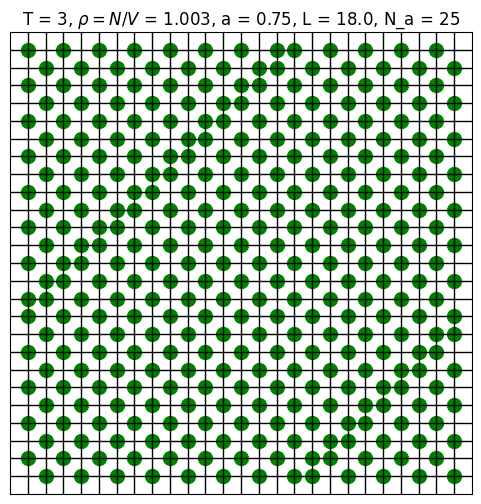

In [30]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np
import tnmpa.solvers.quimb_vbp as qbp
import sys

a = 0.75  # Lattice constant of the underlying simple cubic lattice (in reduced units)
N_a = 25  # Number of lattice points along one direction
L = a * (N_a - 1)  # Length of the cubic box
N = N_a**2  # Total number of lattice
uv = False  # Whether to use UV cutoff
density_compute = True
# chemical_potential = 5
chemical_potential_list = np.arange(280,285,5)
# chemical_potential_list = [0]
reuse = False

dT = 0.1
# T_list = np.arange(1.5, 2, dT)
T_list = [3]
# T_list = np.arange(15.0, 10.0, dT)

cutoff = 3.0  # Cutoff distance for LJ potential
epsilon = 1.0  # Depth of the potential well/ Energy unit scale
sigma = 1.0  # Length scale in LJ potential, also the distance at which the potential becomes zero


# entropy_exact = np.log(contract_HTN_partition(tn))


for T in T_list:
    for chemical_potential in chemical_potential_list:
        beta = 1/T

        tn = qtn.tensor_builder.HTN2D_classical_LennardJones_partition_function(
            Lx=L,Ly=L,
            beta=beta,
            Nx=N_a,Ny=N_a,
            cutoff=cutoff,
            epsilon=epsilon,
            sigma=sigma,
            uv_cutoff=uv,
            chemical_potential=chemical_potential,
            cyclic=True,
            )
        # BP
        converged = False
        tol = 1e-5
        count = 0
        max_dm = 0
        damping_eta = 4e-1
        max_dm_cache = 0
        messages_cache = None

        beta = 1/T
        while not converged:

            if count > 0:
                damping_eta += 5e-2
        
            print('Successfully built the HTN.')

            messages, converged, max_dm = qbp.run_belief_propagation(
            tn, 
            tol=tol,
            max_iterations=2500,
            messages=messages_cache,
            progbar=True,
            thread_pool=8,
            uniform=False,
            damping=True,
            eta=damping_eta,
            show_max_dm=True,
            )

            max_dm_cache = max_dm

            if reuse:
                messages_cache = messages

            entropy_bp = qbp.compute_free_entropy_from_messages(tn, messages)
            density=0
            if density_compute:
                marginal = qbp.compute_all_index_marginals_from_messages(tn, messages)
                key_format='s{},{}'
                # Compute the density
                density = 0
                for i in range(N_a):
                    for j in range(N_a):
                        key = key_format.format(i,j)
                        density += marginal[key][1]
                density /= L**2
            count += 1
            if count>1:
                break
            
        print(f'Free entropy from BP: {entropy_bp}, density: {density}, T: {T}, chemical_potential: {chemical_potential}')
        config_dict = qbp.sample_belief_propagation(tn, messages, None,progbar=True)
        config_dict=config_dict[0]
        # plot a 2D configuration from the config_dict
        # The keys are the 2d coordinates and the values are the particle types (holes or particles)

        import matplotlib.pyplot as plt
        import matplotlib as mpl
        import matplotlib.colors as colors


        # Plot the configuration
        fig, ax = plt.subplots(figsize=(6,6))

        # Plot the lattice grid
        for i in range(N_a):
            ax.plot([i, i], [-1, N_a], color='k', lw=1)
            ax.plot([-1, N_a], [i, i], color='k', lw=1)

        # Plot the particles
        pattern = 's{},{}'
        for i in range(N_a):
            for j in range(N_a):
                key = pattern.format(i,j)
                if config_dict[key] == 1:
                    ax.scatter(i, j, marker='o', color='g', s=100, label='Particle')
                # elif config_dict[key] == 0:
                #     ax.scatter(i, j, marker='o', color='k', s=100)



        ax.set_xlim(-1, N_a)
        ax.set_ylim(-1, N_a)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(r'T = {}, $\rho=N/V$ = {}, a = {}, L = {}, N_a = {}'.format(T, round(density,3), a, L, N_a))
        plt.show()

Successfully built the HTN.


max_dm=8.551574834481102e-06:   4%|▍         | 59/1500 [00:06<02:30,  9.57it/s] 


Free entropy from BP: 3743.051771786296, density: 0.5411318942421212, T: 3, chemical_potential: 0


s49,49->1: 100%|██████████| 10000/10000 [00:47<00:00, 208.81it/s]


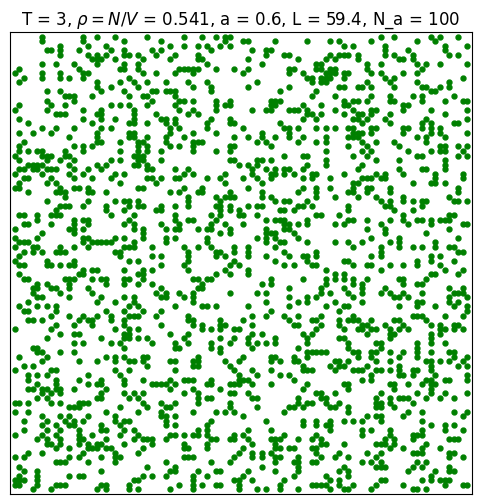

In [38]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np
import tnmpa.solvers.quimb_vbp as qbp
import sys

a = 0.6  # Lattice constant of the underlying simple cubic lattice (in reduced units)
N_a = 100  # Number of lattice points along one direction
L = a * (N_a - 1)  # Length of the cubic box
N = N_a**2  # Total number of lattice
uv = False  # Whether to use UV cutoff
density_compute = True
# chemical_potential = 5
chemical_potential_list = np.arange(0,5,5)
# chemical_potential_list = [0]
reuse = False

dT = 0.1
# T_list = np.arange(1.5, 2, dT)
T_list = [3]
# T_list = np.arange(15.0, 10.0, dT)

cutoff = 3.0  # Cutoff distance for LJ potential
epsilon = 1.0  # Depth of the potential well/ Energy unit scale
sigma = 1.0  # Length scale in LJ potential, also the distance at which the potential becomes zero


# entropy_exact = np.log(contract_HTN_partition(tn))


for T in T_list:
    for chemical_potential in chemical_potential_list:
        beta = 1/T

        tn = qtn.tensor_builder.HTN2D_classical_LennardJones_partition_function(
            Lx=L,Ly=L,
            beta=beta,
            Nx=N_a,Ny=N_a,
            cutoff=cutoff,
            epsilon=epsilon,
            sigma=sigma,
            uv_cutoff=uv,
            chemical_potential=chemical_potential,
            cyclic=True,
            )
        # BP
        converged = False
        tol = 1e-5
        count = 0
        max_dm = 0
        damping_eta = 4e-1
        max_dm_cache = 0
        messages_cache = None

        beta = 1/T
        while not converged:

            if count > 0:
                damping_eta += 5e-2
        
            print('Successfully built the HTN.')

            messages, converged, max_dm = qbp.run_belief_propagation(
            tn, 
            tol=tol,
            max_iterations=1500,
            messages=messages_cache,
            progbar=True,
            thread_pool=8,
            uniform=False,
            damping=True,
            eta=damping_eta,
            show_max_dm=True,
            )

            max_dm_cache = max_dm

            if reuse:
                messages_cache = messages

            entropy_bp = qbp.compute_free_entropy_from_messages(tn, messages)
            density=0
            if density_compute:
                marginal = qbp.compute_all_index_marginals_from_messages(tn, messages)
                key_format='s{},{}'
                # Compute the density
                density = 0
                for i in range(N_a):
                    for j in range(N_a):
                        key = key_format.format(i,j)
                        density += marginal[key][1]
                density /= L**2
            count += 1
            if count>0:
                break
            
        print(f'Free entropy from BP: {entropy_bp}, density: {density}, T: {T}, chemical_potential: {chemical_potential}')
        config_dict = qbp.sample_belief_propagation_no_bp(tn, messages, None,progbar=True)
        config_dict=config_dict[0]
        # plot a 2D configuration from the config_dict
        # The keys are the 2d coordinates and the values are the particle types (holes or particles)

        import matplotlib.pyplot as plt
        import matplotlib as mpl
        import matplotlib.colors as colors


        # Plot the configuration
        fig, ax = plt.subplots(figsize=(6,6))

        # # Plot the lattice grid
        # for i in range(N_a):
        #     ax.plot([i, i], [-1, N_a], color='k', lw=1)
        #     ax.plot([-1, N_a], [i, i], color='k', lw=1)

        # Plot the particles
        pattern = 's{},{}'
        for i in range(N_a):
            for j in range(N_a):
                key = pattern.format(i,j)
                if config_dict[key] == 1:
                    ax.scatter(i, j, marker='.', color='g', s=50, label='Particle')
                # elif config_dict[key] == 0:
                #     ax.scatter(i, j, marker='o', color='k', s=100)



        ax.set_xlim(-1, N_a)
        ax.set_ylim(-1, N_a)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(r'T = {}, $\rho=N/V$ = {}, a = {}, L = {}, N_a = {}'.format(T, round(density,3), a, L, N_a))
        plt.show()

/home/sijingdu/anaconda3/envs/tnmpa/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Successfully built the HTN.


max_dm=7.856806466199906e-06:   3%|▎         | 41/1500 [00:02<01:15, 19.24it/s] 


Free entropy from BP: 223.07825924302944, density: 1.024727073219656, T: 5, chemical_potential: 0


s15,9->1: 100%|██████████| 900/900 [22:05<00:00,  1.47s/it] 


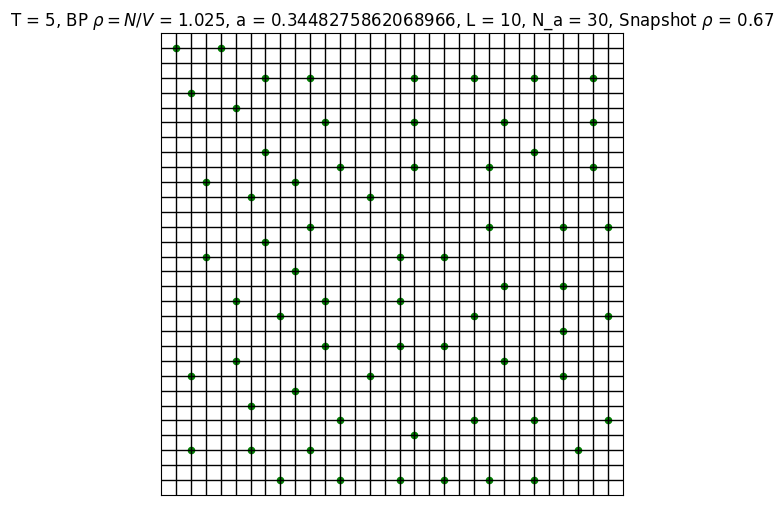

In [1]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np
import tnmpa.solvers.quimb_vbp as qbp
import sys

# a = 0.4  # Lattice constant of the underlying simple cubic lattice (in reduced units)
# N_a = 30  # Number of lattice points along one direction
# L = a * (N_a - 1)  # Length of the cubic box

L = 10
N_a = 30
a = L/(N_a-1)

N = N_a**2  # Total number of lattice
uv = False  # Whether to use UV cutoff
density_compute = True
# chemical_potential = 5
# chemical_potential_list = np.arange(10,15,5)
chemical_potential_list = [0]
reuse = False

dT = 0.1
# T_list = np.arange(2, 2.5, dT)
T_list = [5]
# T_list = np.arange(15.0, 10.0, dT)

cutoff = 3.0  # Cutoff distance for LJ potential
epsilon = 1.0  # Depth of the potential well/ Energy unit scale
sigma = 1.0  # Length scale in LJ potential, also the distance at which the potential becomes zero


# entropy_exact = np.log(contract_HTN_partition(tn))


for T in T_list:
    for chemical_potential in chemical_potential_list:
        beta = 1/T

        tn = qtn.tensor_builder.HTN2D_classical_LennardJones_partition_function(
            Lx=L,Ly=L,
            beta=beta,
            Nx=N_a,Ny=N_a,
            cutoff=cutoff,
            epsilon=epsilon,
            sigma=sigma,
            uv_cutoff=uv,
            chemical_potential=chemical_potential,
            cyclic=True,
            )
        # BP
        converged = False
        tol = 1e-5
        count = 0
        max_dm = 0
        damping_eta = 4e-1
        max_dm_cache = 0
        messages_cache = None

        beta = 1/T
        while not converged:

            if count > 0:
                damping_eta += 5e-2
        
            print('Successfully built the HTN.')

            messages, converged, max_dm = qbp.run_belief_propagation(
            tn, 
            tol=tol,
            max_iterations=1500,
            messages=messages_cache,
            progbar=True,
            thread_pool=8,
            uniform=False,
            damping=True,
            eta=damping_eta,
            show_max_dm=True,
            )

            max_dm_cache = max_dm

            if reuse:
                messages_cache = messages

            entropy_bp = qbp.compute_free_entropy_from_messages(tn, messages)
            density=0
            if density_compute:
                marginal = qbp.compute_all_index_marginals_from_messages(tn, messages)
                key_format='s{},{}'
                # Compute the density
                density = 0
                for i in range(N_a):
                    for j in range(N_a):
                        key = key_format.format(i,j)
                        density += marginal[key][1]
                density /= L**2
            count += 1
            if count>0:
                break
            
        print(f'Free entropy from BP: {entropy_bp}, density: {density}, T: {T}, chemical_potential: {chemical_potential}')
        config_dict = qbp.sample_belief_propagation(tn, messages, None,progbar=True,damping=True,eta=0.3)
        config_dict=config_dict[0]
        # plot a 2D configuration from the config_dict
        # The keys are the 2d coordinates and the values are the particle types (holes or particles)
        import matplotlib.pyplot as plt
        import matplotlib as mpl
        import matplotlib.colors as colors


        # Plot the configuration
        fig, ax = plt.subplots(figsize=(6,6))

        # Plot the lattice grid
        for i in range(N_a):
            ax.plot([i, i], [-1, N_a], color='k', lw=1)
            ax.plot([-1, N_a], [i, i], color='k', lw=1)
        snapshot_density = 0
        # Plot the particles
        pattern = 's{},{}'
        for i in range(N_a):
            for j in range(N_a):
                key = pattern.format(i,j)
                if config_dict[key] == 1:
                    ax.scatter(i, j, marker='o', color='g', s=20, label='Particle')
                    snapshot_density += 1
                # elif config_dict[key] == 0:
                #     ax.scatter(i, j, marker='o', color='k', s=100)
        snapshot_density /= L**2


        ax.set_xlim(-1, N_a)
        ax.set_ylim(-1, N_a)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(r'T = {}, BP $\rho=N/V$ = {}, a = {}, L = {}, N_a = {}, Snapshot $\rho$ = {}'.format(T, round(density,3), a, L, N_a, snapshot_density))
        plt.show()

/home/sijingdu/anaconda3/envs/tnmpa/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Successfully built the HTN.


max_dm=9.311853288757055e-06:  19%|█▉        | 289/1500 [00:02<00:10, 114.38it/s] 


Free entropy from BP: 41867.33461842041, density: 1.0357122260445546, T: 3, chemical_potential: 400


s23,15->0: 100%|██████████| 625/625 [01:37<00:00,  6.44it/s]


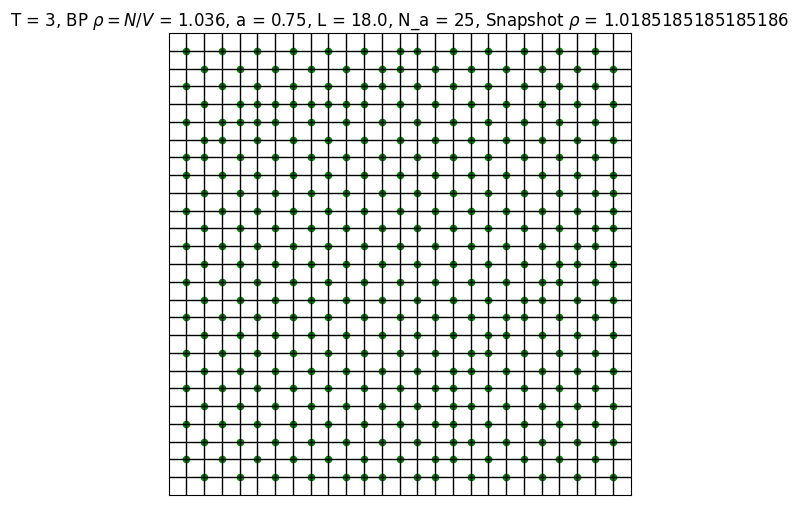

Successfully built the HTN.


max_dm=9.899081638398144e-06:  52%|█████▏    | 779/1500 [00:06<00:06, 117.39it/s] 


Free entropy from BP: 43074.20731975843, density: 1.3756525903535561, T: 3, chemical_potential: 410


s0,9->1: 100%|██████████| 625/625 [01:49<00:00,  5.71it/s]  


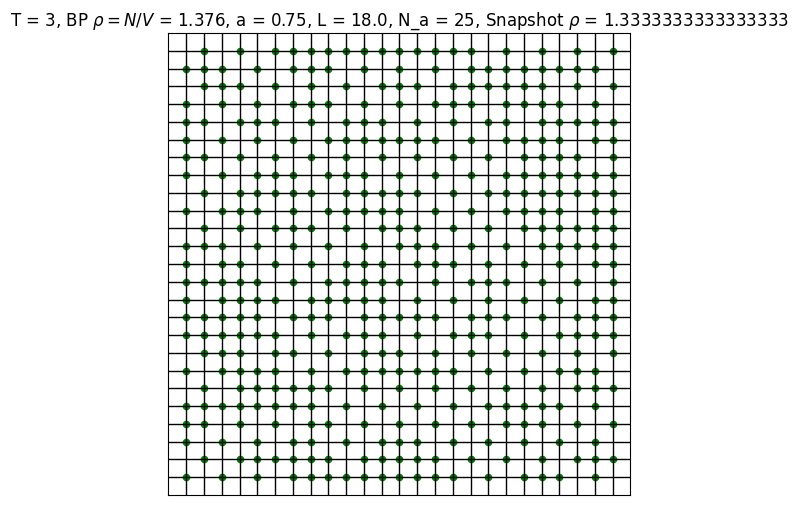

Successfully built the HTN.


max_dm=3.7022535516866364e-05: 100%|██████████| 1500/1500 [00:12<00:00, 124.70it/s]


Free entropy from BP: 44951.30738800671, density: 1.9083695529784466, T: 3, chemical_potential: 420


s5,18->1: 100%|██████████| 625/625 [01:53<00:00,  5.52it/s] 


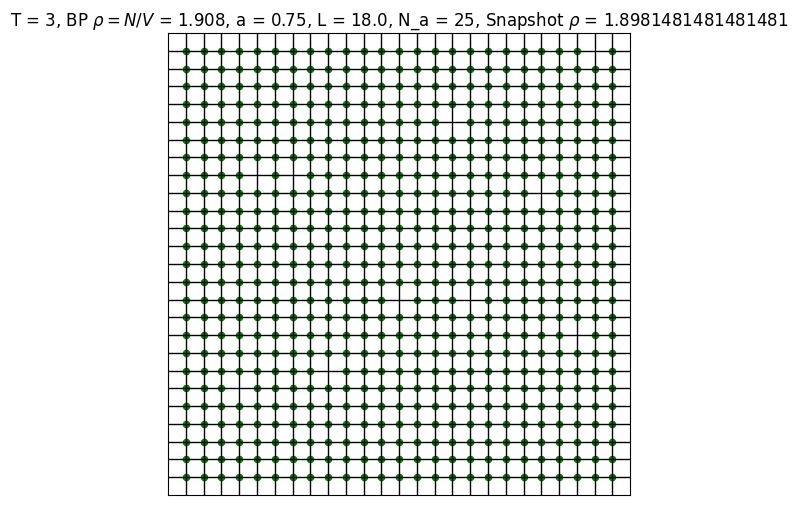

Successfully built the HTN.


max_dm=9.830413715646979e-06:  14%|█▍        | 209/1500 [00:01<00:10, 120.91it/s] 


Free entropy from BP: 47083.497298158436, density: 1.9284624307971847, T: 3, chemical_potential: 430


s17,24->1: 100%|██████████| 625/625 [01:55<00:00,  5.40it/s]


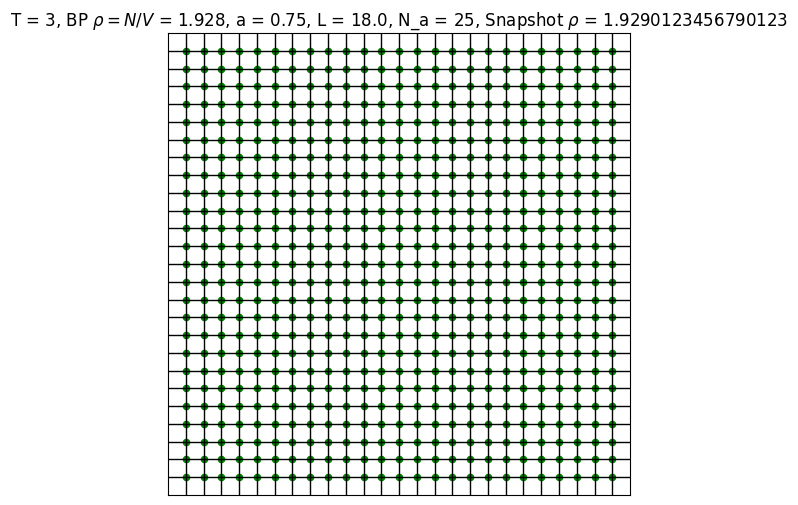

In [1]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np
import tnmpa.solvers.quimb_vbp as qbp
import sys

a = 0.75  # Lattice constant of the underlying simple cubic lattice (in reduced units)
N_a = 25  # Number of lattice points along one direction
L = a * (N_a - 1)  # Length of the cubic box
N = N_a**2  # Total number of lattice
uv = False  # Whether to use UV cutoff
density_compute = True
# chemical_potential = 5
chemical_potential_list = np.arange(400,440,10)
# chemical_potential_list = [0]
reuse = False

dT = 0.1
# T_list = np.arange(1.5, 2, dT)
T_list = [3]
# T_list = np.arange(15.0, 10.0, dT)

cutoff = 3.0  # Cutoff distance for LJ potential
epsilon = 1.0  # Depth of the potential well/ Energy unit scale
sigma = 1.0  # Length scale in LJ potential, also the distance at which the potential becomes zero


# entropy_exact = np.log(contract_HTN_partition(tn))


for T in T_list:
    for chemical_potential in chemical_potential_list:
        beta = 1/T

        tn = qtn.tensor_builder.HTN2D_classical_LennardJones_partition_function(
            Lx=L,Ly=L,
            beta=beta,
            Nx=N_a,Ny=N_a,
            cutoff=cutoff,
            epsilon=epsilon,
            sigma=sigma,
            uv_cutoff=uv,
            chemical_potential=chemical_potential,
            cyclic=True,
            )
        # BP
        converged = False
        tol = 1e-5
        count = 0
        max_dm = 0
        damping_eta = 4e-1
        max_dm_cache = 0
        messages_cache = None

        beta = 1/T
        while not converged:

            if count > 0:
                damping_eta += 5e-2
        
            print('Successfully built the HTN.')

            messages, converged, max_dm = qbp.run_belief_propagation(
            tn, 
            tol=tol,
            max_iterations=1500,
            messages=messages_cache,
            progbar=True,
            thread_pool=8,
            uniform=False,
            damping=True,
            eta=damping_eta,
            show_max_dm=True,
            )

            max_dm_cache = max_dm

            if reuse:
                messages_cache = messages

            entropy_bp = qbp.compute_free_entropy_from_messages(tn, messages)
            density=0
            if density_compute:
                marginal = qbp.compute_all_index_marginals_from_messages(tn, messages)
                key_format='s{},{}'
                # Compute the density
                density = 0
                for i in range(N_a):
                    for j in range(N_a):
                        key = key_format.format(i,j)
                        density += marginal[key][1]
                density /= L**2
            count += 1
            if count>0:
                break
            
        print(f'Free entropy from BP: {entropy_bp}, density: {density}, T: {T}, chemical_potential: {chemical_potential}')
        config_dict = qbp.sample_belief_propagation(tn, messages, None,progbar=True)
        config_dict=config_dict[0]
        # plot a 2D configuration from the config_dict
        # The keys are the 2d coordinates and the values are the particle types (holes or particles)

        import matplotlib.pyplot as plt
        import matplotlib as mpl
        import matplotlib.colors as colors


        # Plot the configuration
        fig, ax = plt.subplots(figsize=(6,6))

        # Plot the lattice grid
        for i in range(N_a):
            ax.plot([i, i], [-1, N_a], color='k', lw=1)
            ax.plot([-1, N_a], [i, i], color='k', lw=1)
        snapshot_density = 0
        # Plot the particles
        pattern = 's{},{}'
        for i in range(N_a):
            for j in range(N_a):
                key = pattern.format(i,j)
                if config_dict[key] == 1:
                    ax.scatter(i, j, marker='o', color='g', s=20, label='Particle')
                    snapshot_density += 1
                # elif config_dict[key] == 0:
                #     ax.scatter(i, j, marker='o', color='k', s=100)
        snapshot_density /= L**2


        ax.set_xlim(-1, N_a)
        ax.set_ylim(-1, N_a)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(r'T = {}, BP $\rho=N/V$ = {}, a = {}, L = {}, N_a = {}, Snapshot $\rho$ = {}'.format(T, round(density,3), a, L, N_a, snapshot_density))
        plt.show()